In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [ ]:
# Import dataset
train_data = pd.read_csv("../../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../../datasets/electricity/test.csv", index_col="date")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

# Concatenate to get the full data
full_data = pd.concat([train_data,val_data,test_data])

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 48
prediction_length = 24

 # Function to create datasets and dataloaders
def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )
    dataset.add_timestamp_encodings()

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 3,
        batch_size = 128,
    )

    return dataloader, dataset


In [5]:
# Create datasets and loaders
train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)


In [6]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = int(2*train_dataset.data.shape[1]),
    residual_layers = 8,
    residual_hidden =  int(3*train_dataset.data.shape[1]*0.333),
    dropout = 0.01,
    scaling = True,
    device = device,
    residual_scaler = True
)


/rds/general/user/ejh19/home/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [7]:
optimizer = torch.optim.Adam(params=predictor.parameters(), lr=1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=100)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    disable_progress_bar = False,
)

Epoch: 1/200: 100%|██████████| 113/113 [00:04<00:00, 26.21batch/s, Training loss=0.9730]


val_loss: 0.8682 , 


Epoch: 2/200: 100%|██████████| 113/113 [00:04<00:00, 26.12batch/s, Training loss=0.7048]


val_loss: 0.5554 , 


Epoch: 3/200: 100%|██████████| 113/113 [00:04<00:00, 25.56batch/s, Training loss=0.4463]


val_loss: 0.3620 , 


Epoch: 4/200: 100%|██████████| 113/113 [00:04<00:00, 26.55batch/s, Training loss=0.3017]


val_loss: 0.2606 , 


Epoch: 5/200: 100%|██████████| 113/113 [00:04<00:00, 26.62batch/s, Training loss=0.2308]


val_loss: 0.2178 , 


Epoch: 6/200: 100%|██████████| 113/113 [00:04<00:00, 26.55batch/s, Training loss=0.2035]


val_loss: 0.2094 , 


Epoch: 7/200: 100%|██████████| 113/113 [00:04<00:00, 26.04batch/s, Training loss=0.1889]


val_loss: 0.1957 , 


Epoch: 8/200: 100%|██████████| 113/113 [00:04<00:00, 26.21batch/s, Training loss=0.1830]


val_loss: 0.1912 , 


Epoch: 9/200: 100%|██████████| 113/113 [00:04<00:00, 26.64batch/s, Training loss=0.1705]


val_loss: 0.1784 , 


Epoch: 10/200: 100%|██████████| 113/113 [00:04<00:00, 26.04batch/s, Training loss=0.1703]


val_loss: 0.1776 , 


Epoch: 11/200: 100%|██████████| 113/113 [00:04<00:00, 25.98batch/s, Training loss=0.1654]


val_loss: 0.1772 , 


Epoch: 12/200: 100%|██████████| 113/113 [00:04<00:00, 25.99batch/s, Training loss=0.1641]


val_loss: 0.1802 , 


Epoch: 13/200: 100%|██████████| 113/113 [00:04<00:00, 25.53batch/s, Training loss=0.1579]


val_loss: 0.1670 , 


Epoch: 14/200: 100%|██████████| 113/113 [00:04<00:00, 25.54batch/s, Training loss=0.1507]


val_loss: 0.1567 , 


Epoch: 15/200: 100%|██████████| 113/113 [00:04<00:00, 25.44batch/s, Training loss=0.1531]


val_loss: 0.1631 , 


Epoch: 16/200: 100%|██████████| 113/113 [00:04<00:00, 25.60batch/s, Training loss=0.1503]


val_loss: 0.1657 , 


Epoch: 17/200: 100%|██████████| 113/113 [00:04<00:00, 26.15batch/s, Training loss=0.1508]


val_loss: 0.1591 , 


Epoch: 18/200: 100%|██████████| 113/113 [00:04<00:00, 26.45batch/s, Training loss=0.1458]


val_loss: 0.1582 , 


Epoch: 19/200: 100%|██████████| 113/113 [00:04<00:00, 26.07batch/s, Training loss=0.1423]


val_loss: 0.1583 , 


Epoch: 20/200: 100%|██████████| 113/113 [00:04<00:00, 26.01batch/s, Training loss=0.1411]


val_loss: 0.1502 , 


Epoch: 21/200: 100%|██████████| 113/113 [00:04<00:00, 25.65batch/s, Training loss=0.1412]


val_loss: 0.1515 , 


Epoch: 22/200: 100%|██████████| 113/113 [00:04<00:00, 25.77batch/s, Training loss=0.1366]


val_loss: 0.1557 , 


Epoch: 23/200: 100%|██████████| 113/113 [00:04<00:00, 25.84batch/s, Training loss=0.1353]


val_loss: 0.1469 , 


Epoch: 24/200: 100%|██████████| 113/113 [00:04<00:00, 25.42batch/s, Training loss=0.1353]


val_loss: 0.1421 , 


Epoch: 25/200: 100%|██████████| 113/113 [00:04<00:00, 25.82batch/s, Training loss=0.1342]


val_loss: 0.1465 , 


Epoch: 26/200: 100%|██████████| 113/113 [00:04<00:00, 26.46batch/s, Training loss=0.1323]


val_loss: 0.1498 , 


Epoch: 27/200: 100%|██████████| 113/113 [00:04<00:00, 26.06batch/s, Training loss=0.1297]


val_loss: 0.1388 , 


Epoch: 28/200: 100%|██████████| 113/113 [00:04<00:00, 25.29batch/s, Training loss=0.1297]


val_loss: 0.1424 , 


Epoch: 29/200: 100%|██████████| 113/113 [00:04<00:00, 26.45batch/s, Training loss=0.1306]


val_loss: 0.1424 , 


Epoch: 30/200: 100%|██████████| 113/113 [00:04<00:00, 25.74batch/s, Training loss=0.1277]


val_loss: 0.1421 , 


Epoch: 31/200: 100%|██████████| 113/113 [00:04<00:00, 25.55batch/s, Training loss=0.1263]


val_loss: 0.1416 , 


Epoch: 32/200: 100%|██████████| 113/113 [00:04<00:00, 26.62batch/s, Training loss=0.1275]


val_loss: 0.1379 , 


Epoch: 33/200: 100%|██████████| 113/113 [00:04<00:00, 26.33batch/s, Training loss=0.1252]


val_loss: 0.1429 , 


Epoch: 34/200: 100%|██████████| 113/113 [00:04<00:00, 26.10batch/s, Training loss=0.1268]


val_loss: 0.1374 , 


Epoch: 35/200: 100%|██████████| 113/113 [00:04<00:00, 26.43batch/s, Training loss=0.1243]


val_loss: 0.1361 , 


Epoch: 36/200: 100%|██████████| 113/113 [00:04<00:00, 25.74batch/s, Training loss=0.1215]


val_loss: 0.1367 , 


Epoch: 37/200: 100%|██████████| 113/113 [00:04<00:00, 25.49batch/s, Training loss=0.1237]


val_loss: 0.1380 , 


Epoch: 38/200: 100%|██████████| 113/113 [00:04<00:00, 25.63batch/s, Training loss=0.1223]


val_loss: 0.1337 , 


Epoch: 39/200: 100%|██████████| 113/113 [00:04<00:00, 26.04batch/s, Training loss=0.1238]


val_loss: 0.1362 , 


Epoch: 40/200: 100%|██████████| 113/113 [00:04<00:00, 25.61batch/s, Training loss=0.1183]


val_loss: 0.1404 , 


Epoch: 41/200: 100%|██████████| 113/113 [00:04<00:00, 26.26batch/s, Training loss=0.1184]


val_loss: 0.1308 , 


Epoch: 42/200: 100%|██████████| 113/113 [00:04<00:00, 25.81batch/s, Training loss=0.1199]


val_loss: 0.1385 , 


Epoch: 43/200: 100%|██████████| 113/113 [00:04<00:00, 25.82batch/s, Training loss=0.1180]


val_loss: 0.1360 , 


Epoch: 44/200: 100%|██████████| 113/113 [00:04<00:00, 25.65batch/s, Training loss=0.1194]


val_loss: 0.1322 , 


Epoch: 45/200: 100%|██████████| 113/113 [00:04<00:00, 25.75batch/s, Training loss=0.1161]


val_loss: 0.1315 , 


Epoch: 46/200: 100%|██████████| 113/113 [00:04<00:00, 25.95batch/s, Training loss=0.1176]


val_loss: 0.1205 , 


Epoch: 47/200: 100%|██████████| 113/113 [00:04<00:00, 26.38batch/s, Training loss=0.1160]


val_loss: 0.1367 , 


Epoch: 48/200: 100%|██████████| 113/113 [00:04<00:00, 26.03batch/s, Training loss=0.1151]


val_loss: 0.1240 , 


Epoch: 49/200: 100%|██████████| 113/113 [00:04<00:00, 25.60batch/s, Training loss=0.1170]


val_loss: 0.1277 , 


Epoch: 50/200: 100%|██████████| 113/113 [00:04<00:00, 25.93batch/s, Training loss=0.1130]


val_loss: 0.1291 , 


Epoch: 51/200: 100%|██████████| 113/113 [00:04<00:00, 26.01batch/s, Training loss=0.1098]


val_loss: 0.1294 , 


Epoch: 52/200: 100%|██████████| 113/113 [00:04<00:00, 26.16batch/s, Training loss=0.1113]


val_loss: 0.1297 , 


Epoch: 53/200: 100%|██████████| 113/113 [00:04<00:00, 25.79batch/s, Training loss=0.1134]


val_loss: 0.1256 , 


Epoch: 54/200: 100%|██████████| 113/113 [00:04<00:00, 25.49batch/s, Training loss=0.1114]


val_loss: 0.1233 , 


Epoch: 55/200: 100%|██████████| 113/113 [00:04<00:00, 26.41batch/s, Training loss=0.1085]


val_loss: 0.1238 , 


Epoch: 56/200: 100%|██████████| 113/113 [00:04<00:00, 25.91batch/s, Training loss=0.1071]


val_loss: 0.1268 , 


Epoch: 57/200: 100%|██████████| 113/113 [00:04<00:00, 25.48batch/s, Training loss=0.1090]


val_loss: 0.1216 , 


Epoch: 58/200: 100%|██████████| 113/113 [00:04<00:00, 25.55batch/s, Training loss=0.1061]


val_loss: 0.1178 , 


Epoch: 59/200: 100%|██████████| 113/113 [00:04<00:00, 25.26batch/s, Training loss=0.1048]


val_loss: 0.1138 , 


Epoch: 60/200: 100%|██████████| 113/113 [00:04<00:00, 25.74batch/s, Training loss=0.1074]


val_loss: 0.1207 , 


Epoch: 61/200: 100%|██████████| 113/113 [00:04<00:00, 26.21batch/s, Training loss=0.1066]


val_loss: 0.1240 , 


Epoch: 62/200: 100%|██████████| 113/113 [00:04<00:00, 25.79batch/s, Training loss=0.1055]


val_loss: 0.1236 , 


Epoch: 63/200: 100%|██████████| 113/113 [00:04<00:00, 25.63batch/s, Training loss=0.1053]


val_loss: 0.1220 , 


Epoch: 64/200: 100%|██████████| 113/113 [00:04<00:00, 25.87batch/s, Training loss=0.1036]


val_loss: 0.1246 , 


Epoch: 65/200: 100%|██████████| 113/113 [00:04<00:00, 26.15batch/s, Training loss=0.1049]


val_loss: 0.1262 , 


Epoch: 66/200: 100%|██████████| 113/113 [00:04<00:00, 25.89batch/s, Training loss=0.1032]


val_loss: 0.1165 , 


Epoch: 67/200: 100%|██████████| 113/113 [00:04<00:00, 25.96batch/s, Training loss=0.1011]


val_loss: 0.1179 , 


Epoch: 68/200: 100%|██████████| 113/113 [00:04<00:00, 25.68batch/s, Training loss=0.1044]


val_loss: 0.1233 , 


Epoch: 69/200: 100%|██████████| 113/113 [00:04<00:00, 25.61batch/s, Training loss=0.1005]


val_loss: 0.1196 , 


Epoch: 70/200: 100%|██████████| 113/113 [00:04<00:00, 26.20batch/s, Training loss=0.1046]


val_loss: 0.1212 , 


Epoch: 71/200: 100%|██████████| 113/113 [00:04<00:00, 25.42batch/s, Training loss=0.1040]


val_loss: 0.1096 , 


Epoch: 72/200: 100%|██████████| 113/113 [00:04<00:00, 25.38batch/s, Training loss=0.0994]


val_loss: 0.1213 , 


Epoch: 73/200: 100%|██████████| 113/113 [00:04<00:00, 25.51batch/s, Training loss=0.1034]


val_loss: 0.1138 , 


Epoch: 74/200: 100%|██████████| 113/113 [00:04<00:00, 25.69batch/s, Training loss=0.0976]


val_loss: 0.1186 , 


Epoch: 75/200: 100%|██████████| 113/113 [00:04<00:00, 25.41batch/s, Training loss=0.1018]


val_loss: 0.1158 , 


Epoch: 76/200: 100%|██████████| 113/113 [00:04<00:00, 25.53batch/s, Training loss=0.0984]


val_loss: 0.1248 , 


Epoch: 77/200: 100%|██████████| 113/113 [00:04<00:00, 26.02batch/s, Training loss=0.0990]


val_loss: 0.1179 , 


Epoch: 78/200: 100%|██████████| 113/113 [00:04<00:00, 25.78batch/s, Training loss=0.1013]


val_loss: 0.1191 , 


Epoch: 79/200: 100%|██████████| 113/113 [00:04<00:00, 25.95batch/s, Training loss=0.0955]


val_loss: 0.1157 , 


Epoch: 80/200: 100%|██████████| 113/113 [00:04<00:00, 26.33batch/s, Training loss=0.0974]


val_loss: 0.1180 , 


Epoch: 81/200: 100%|██████████| 113/113 [00:04<00:00, 25.06batch/s, Training loss=0.0978]


val_loss: 0.1076 , 


Epoch: 82/200: 100%|██████████| 113/113 [00:04<00:00, 25.63batch/s, Training loss=0.0951]


val_loss: 0.1106 , 


Epoch: 83/200: 100%|██████████| 113/113 [00:04<00:00, 25.59batch/s, Training loss=0.0967]


val_loss: 0.1137 , 


Epoch: 84/200: 100%|██████████| 113/113 [00:04<00:00, 25.09batch/s, Training loss=0.0923]


val_loss: 0.1156 , 


Epoch: 85/200: 100%|██████████| 113/113 [00:04<00:00, 25.02batch/s, Training loss=0.0938]


val_loss: 0.1112 , 


Epoch: 86/200: 100%|██████████| 113/113 [00:04<00:00, 26.18batch/s, Training loss=0.0965]


val_loss: 0.1120 , 


Epoch: 87/200: 100%|██████████| 113/113 [00:04<00:00, 26.12batch/s, Training loss=0.0957]


val_loss: 0.1091 , 


Epoch: 88/200: 100%|██████████| 113/113 [00:04<00:00, 26.38batch/s, Training loss=0.0932]


val_loss: 0.1131 , 


Epoch: 89/200: 100%|██████████| 113/113 [00:04<00:00, 26.04batch/s, Training loss=0.0932]


val_loss: 0.1121 , 


Epoch: 90/200: 100%|██████████| 113/113 [00:04<00:00, 25.34batch/s, Training loss=0.0942]


val_loss: 0.1140 , 


Epoch: 91/200: 100%|██████████| 113/113 [00:04<00:00, 26.18batch/s, Training loss=0.0929]


val_loss: 0.1067 , 


Epoch: 92/200: 100%|██████████| 113/113 [00:04<00:00, 25.12batch/s, Training loss=0.0926]


val_loss: 0.1040 , 


Epoch: 93/200: 100%|██████████| 113/113 [00:04<00:00, 26.46batch/s, Training loss=0.0944]


val_loss: 0.1157 , 


Epoch: 94/200: 100%|██████████| 113/113 [00:04<00:00, 25.28batch/s, Training loss=0.0886]


val_loss: 0.1159 , 


Epoch: 95/200: 100%|██████████| 113/113 [00:04<00:00, 24.86batch/s, Training loss=0.0908]


val_loss: 0.1145 , 


Epoch: 96/200: 100%|██████████| 113/113 [00:04<00:00, 26.56batch/s, Training loss=0.0896]


val_loss: 0.1067 , 


Epoch: 97/200: 100%|██████████| 113/113 [00:04<00:00, 26.38batch/s, Training loss=0.0885]


val_loss: 0.1109 , 


Epoch: 98/200: 100%|██████████| 113/113 [00:04<00:00, 25.40batch/s, Training loss=0.0917]


val_loss: 0.1098 , 


Epoch: 99/200: 100%|██████████| 113/113 [00:04<00:00, 25.92batch/s, Training loss=0.0883]


val_loss: 0.1154 , 


Epoch: 100/200: 100%|██████████| 113/113 [00:04<00:00, 25.16batch/s, Training loss=0.0899]


val_loss: 0.1024 , 


Epoch: 101/200: 100%|██████████| 113/113 [00:04<00:00, 25.65batch/s, Training loss=0.0888]


val_loss: 0.1089 , 


Epoch: 102/200: 100%|██████████| 113/113 [00:04<00:00, 26.91batch/s, Training loss=0.0888]


val_loss: 0.1087 , 


Epoch: 103/200: 100%|██████████| 113/113 [00:04<00:00, 27.05batch/s, Training loss=0.0870]


val_loss: 0.1103 , 


Epoch: 104/200: 100%|██████████| 113/113 [00:04<00:00, 27.18batch/s, Training loss=0.0881]


val_loss: 0.1086 , 


Epoch: 105/200: 100%|██████████| 113/113 [00:04<00:00, 27.14batch/s, Training loss=0.0880]


val_loss: 0.1051 , 


Epoch: 106/200: 100%|██████████| 113/113 [00:04<00:00, 26.97batch/s, Training loss=0.0878]


val_loss: 0.1085 , 


Epoch: 107/200: 100%|██████████| 113/113 [00:04<00:00, 26.93batch/s, Training loss=0.0852]


val_loss: 0.1102 , 


Epoch: 108/200: 100%|██████████| 113/113 [00:04<00:00, 26.65batch/s, Training loss=0.0857]


val_loss: 0.1043 , 


Epoch: 109/200: 100%|██████████| 113/113 [00:04<00:00, 26.98batch/s, Training loss=0.0866]


val_loss: 0.1076 , 


Epoch: 110/200: 100%|██████████| 113/113 [00:04<00:00, 27.19batch/s, Training loss=0.0891]


val_loss: 0.1126 , 


Epoch: 111/200: 100%|██████████| 113/113 [00:04<00:00, 27.14batch/s, Training loss=0.0894]


val_loss: 0.1097 , 


Epoch: 112/200: 100%|██████████| 113/113 [00:04<00:00, 27.17batch/s, Training loss=0.0873]


val_loss: 0.1118 , 


Epoch: 113/200: 100%|██████████| 113/113 [00:04<00:00, 26.86batch/s, Training loss=0.0873]


val_loss: 0.1101 , 


Epoch: 114/200: 100%|██████████| 113/113 [00:04<00:00, 27.19batch/s, Training loss=0.0872]


val_loss: 0.1045 , 


Epoch: 115/200: 100%|██████████| 113/113 [00:04<00:00, 27.03batch/s, Training loss=0.0867]


val_loss: 0.1086 , 


Epoch: 116/200: 100%|██████████| 113/113 [00:04<00:00, 27.08batch/s, Training loss=0.0909]


val_loss: 0.1083 , 


Epoch: 117/200: 100%|██████████| 113/113 [00:04<00:00, 26.46batch/s, Training loss=0.0901]


val_loss: 0.0974 , 


Epoch: 118/200: 100%|██████████| 113/113 [00:04<00:00, 26.42batch/s, Training loss=0.0842]


val_loss: 0.1034 , 


Epoch: 119/200: 100%|██████████| 113/113 [00:04<00:00, 26.12batch/s, Training loss=0.0857]


val_loss: 0.1037 , 


Epoch: 120/200: 100%|██████████| 113/113 [00:04<00:00, 27.01batch/s, Training loss=0.0871]


val_loss: 0.1083 , 


Epoch: 121/200: 100%|██████████| 113/113 [00:04<00:00, 27.13batch/s, Training loss=0.0898]


val_loss: 0.1033 , 


Epoch: 122/200: 100%|██████████| 113/113 [00:04<00:00, 27.26batch/s, Training loss=0.0857]


val_loss: 0.1046 , 


Epoch: 123/200: 100%|██████████| 113/113 [00:04<00:00, 27.18batch/s, Training loss=0.0892]


val_loss: 0.1105 , 


Epoch: 124/200: 100%|██████████| 113/113 [00:04<00:00, 27.31batch/s, Training loss=0.0899]


val_loss: 0.0996 , 


Epoch: 125/200: 100%|██████████| 113/113 [00:04<00:00, 27.41batch/s, Training loss=0.0879]


val_loss: 0.1071 , 


Epoch: 126/200: 100%|██████████| 113/113 [00:04<00:00, 27.28batch/s, Training loss=0.0896]


val_loss: 0.1089 , 


Epoch: 127/200: 100%|██████████| 113/113 [00:04<00:00, 27.29batch/s, Training loss=0.0881]


val_loss: 0.1033 , 


Epoch: 128/200: 100%|██████████| 113/113 [00:04<00:00, 27.34batch/s, Training loss=0.0860]


val_loss: 0.1078 , 


Epoch: 129/200: 100%|██████████| 113/113 [00:04<00:00, 27.38batch/s, Training loss=0.0881]


val_loss: 0.0990 , 


Epoch: 130/200: 100%|██████████| 113/113 [00:04<00:00, 27.06batch/s, Training loss=0.0866]


val_loss: 0.1016 , 


Epoch: 131/200: 100%|██████████| 113/113 [00:04<00:00, 26.95batch/s, Training loss=0.0872]


val_loss: 0.1060 , 


Epoch: 132/200: 100%|██████████| 113/113 [00:04<00:00, 27.18batch/s, Training loss=0.0878]


val_loss: 0.1121 , 


Epoch: 133/200: 100%|██████████| 113/113 [00:04<00:00, 27.23batch/s, Training loss=0.0880]


val_loss: 0.1035 , 


Epoch: 134/200: 100%|██████████| 113/113 [00:04<00:00, 27.38batch/s, Training loss=0.0890]


val_loss: 0.1060 , 


Epoch: 135/200: 100%|██████████| 113/113 [00:04<00:00, 27.35batch/s, Training loss=0.0890]


val_loss: 0.1107 , 


Epoch: 136/200: 100%|██████████| 113/113 [00:04<00:00, 27.28batch/s, Training loss=0.0871]


val_loss: 0.1085 , 


Epoch: 137/200: 100%|██████████| 113/113 [00:04<00:00, 26.23batch/s, Training loss=0.0866]


val_loss: 0.1050 , 


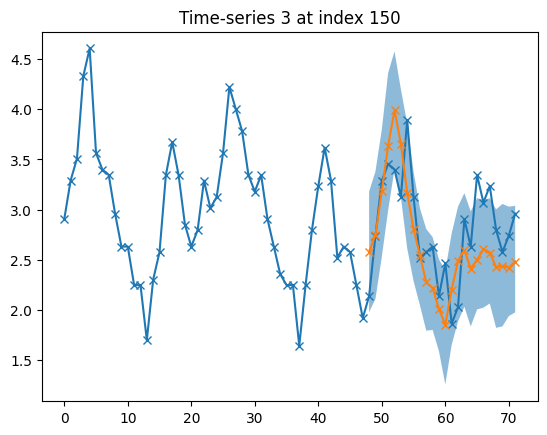

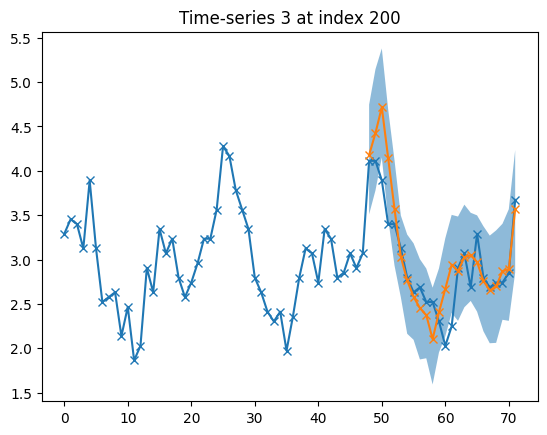

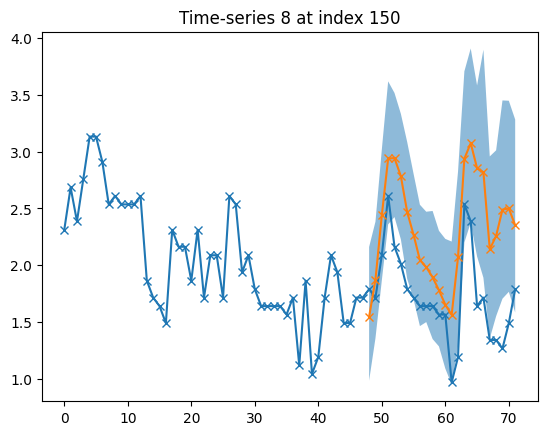

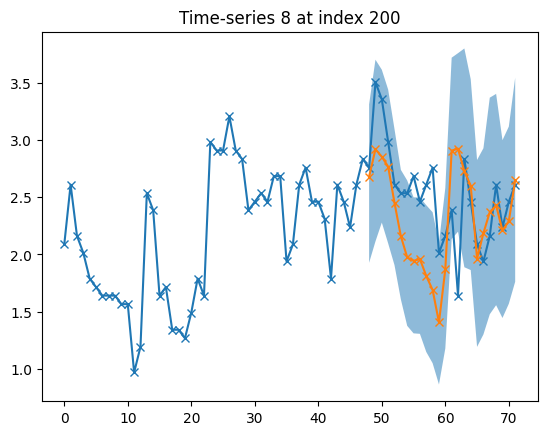

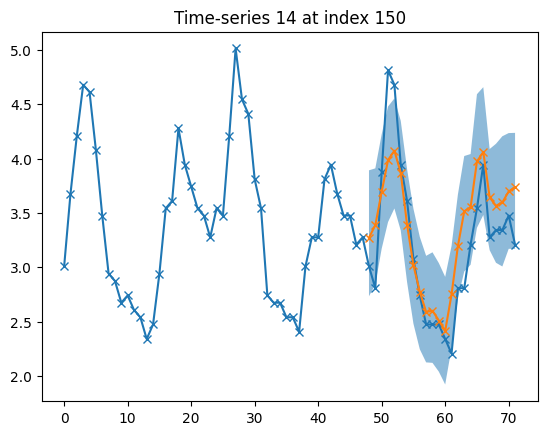

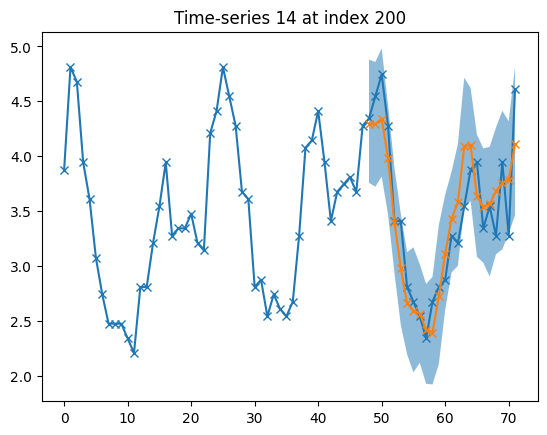

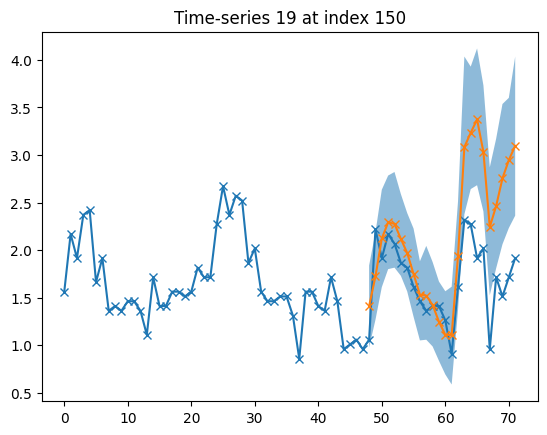

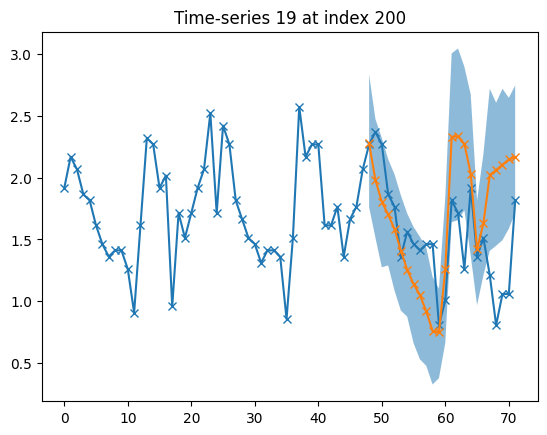

In [8]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [11]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*14, 24))

last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))


max_anchors = []
min_anchors = []
for idx in indices:
    max_values = full_data.loc[full_data.index < val_data.index[idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))



samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.00,
)
samples = samples.cpu()


realisations = []
for idx in indices:
    realisations.append(
        val_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,val_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


In [12]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.21549869 MAE: 0.31740585 MDAE: 0.22467628
CRPS_sum: 15.266027487459636 Variogram_score: 0.06965211097796456


In [13]:
# Make samples and extract realisations for last 14 days of test dataset
#indices = list(range(0, 24*14, 24))

last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))

max_anchors = 1.1*torch.tensor(train_data.values.max(axis=0),dtype=torch.float32,device=device) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32,device=device)
min_anchors = 1.1*torch.tensor(train_data.values.min(axis=0),dtype=torch.float32,device=device) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32,device=device)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(0).unsqueeze(2).repeat((14,1,prediction_length,1))


samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.0,
)
samples = samples.cpu()


realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,test_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


In [14]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.16737008 MAE: 0.27584964 MDAE: 0.18680179
CRPS_sum: 13.571457280999137 Variogram_score: 0.061341738543476014


In [ ]:
a = ((realisations - mean_predictions) ** 2).mean(axis=2)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
((realisations - mean_predictions) ** 2).mean(axis=2).max(axis=1)

In [ ]:
plt.plot(mean_predictions[6,55])
plt.plot(realisations[6,55])

In [ ]:
# Load weights as an alternative to training
predictor.load_state_dict(torch.load("weights/electricity/2023-05-26-01-05-47",map_location=device))
predictor.eval()

In [ ]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [ ]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*14, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [ ]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

In [ ]:
# Sampling with min/max anchors
indices = list(range(0, 24*14, 24))

max_anchors = 1.1*torch.tensor(train_data.values.max(axis=0),dtype=torch.float32) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32)
min_anchors = 1.1*torch.tensor(train_data.values.min(axis=0),dtype=torch.float32) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(0).unsqueeze(2).repeat((len(indices),1,prediction_length,1))


samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors = anchors,
    anchor_strength = 0.01,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)

In [ ]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

In [ ]:
# Check how accurate quantiles are
quantiles = []
for i in range(samples.shape[0]):
    sorted_samples,_ = torch.tensor(samples[i]).flatten(start_dim=1).sort(dim=0)
    real_copy = torch.tensor(realisations[i]).flatten()

    quantiles.append([float((sorted_samples[:,i]<val).double().mean()) for i,val in enumerate(real_copy)])

plt.title("Distribution of quantile positions of realisations")
_ = plt.hist(np.array(quantiles).flatten(),20)